### Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from imblearn.over_sampling import SMOTE

from MachineLearning import models

### Read Databases

In [2]:
local_view = pd.read_csv(
    "Preprocessed\preprocessed_local_view.csv", sep=",")
global_view = pd.read_csv(
    "Preprocessed\preprocessed_global_view.csv", sep=",")

local_view.drop(["Unnamed: 0"], axis=1, inplace=True)
global_view.drop(["Unnamed: 0"], axis=1, inplace=True)

dropna_list = [local_view, global_view]

for var in dropna_list:
    var.dropna(inplace=True)
    
print("\n============================================================================================================")
print("Checking base balance: ")

targets = pd.concat([local_view[['label']].rename(columns={'label': 'target_local'}), global_view[[
                    'label']].rename(columns={'label': 'target_global'})], axis=0, ignore_index=True)
counts = targets.apply(pd.Series.value_counts).fillna(0).astype(int)

print(counts)


Checking base balance: 
                target_local  target_global
FALSE POSITIVE          4744           4215
CONFIRMED               2639           2429


### Transform target column values ​​into 0 and 1

In [3]:
target_map = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
local_view['label'] = local_view['label'].map(target_map)
global_view['label'] = global_view['label'].map(target_map)

### Separating into training and testing

In [4]:
# ============= Separating into X and y =============

X_local = local_view.iloc[:, :-1]
X_global = global_view.iloc[:, :-1]

y_local = local_view['label']
y_global = global_view['label']

# ============= Separating into training and testing =============

X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
    X_local, y_local, test_size= 0.3, random_state=42, stratify=y_local)

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_global, y_global, test_size= 0.3, random_state=42, stratify=y_global)

### Smote balancing

In [5]:
# Smote balancing
smote = SMOTE()  # Create a SMOTE instance
X_train_local, y_train_local = smote.fit_resample(X_train_local, y_train_local)  # Apply SMOTE to data local
X_train_global, y_train_global = smote.fit_resample(X_train_global, y_train_global)  # Apply SMOTE to data global

### All models and parameters of classification models

In [6]:
models_and_parameters_C = {
    'AdaBoostClassifier': {
        'clf': AdaBoostClassifier(random_state=42),
        'parameters': {
            'n_estimators': range(60, 220, 40)
        },
    },
    'XGBClassifier': {
        'clf': xgb.XGBClassifier(objective = "binary:logistic", random_state=42),
        'parameters': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5]
        }
    },
    # 'SVM': {
    #     'clf': SVC(probability=True, random_state=42),
    #     'parameters': {
    #         'C': [1, 3, 5, 10, 15],
    #         'kernel': ['linear', 'rbf'],
    #         'tol': [1e-3, 1e-4]
    #     },
    # },
    # 'MLPClassifier': {
    #     'clf': MLPClassifier(random_state=42),
    #     'parameters': {
    #         'solver': ['sgd', 'adam'], 
    #         'max_iter': [1000, 1300, 1500, 2000], 
    #         'alpha': 10.0 ** -np.arange(1, 10), 
    #         'hidden_layer_sizes':np.arange(10, 15),
    #         'tol': [1e-3, 1e-4]
    #     },
    # },
}

### Classifier models

In [7]:
# models.defining_classifiers(models_and_parameters_C, X_train_local, y_train_local, X_test_local, y_test_local, "local")
# models.defining_classifiers(models_and_parameters_C, X_train_global, y_train_global, X_test_global, y_test_global, "global")

### Dynamic selection of classifiers

In [8]:
models.dynamic_selection_of_classifiers(models_and_parameters_C, X_train_local, y_train_local, X_test_local, y_test_local, "local")


================================== Dynamic Selection ==================================
Model: AdaBoostClassifier

- Running models on data in a local vision

================================== Dynamic Selection ==================================
Model: XGBClassifier

- Running models on data in a _local vision

Runtime: 1821.02 seconds

Accuracy using KNORAU with different classifiers: 0.6857787810383748

Accuracy using KNORAE with different classifiers: 0.6862302483069977


In [7]:
models.dynamic_selection_of_classifiers(models_and_parameters_C, X_train_global, y_train_global, X_test_global, y_test_global, "global")


================================== Dynamic Selection ==================================
Model: AdaBoostClassifier

- Running models on data in a global vision

================================== Dynamic Selection ==================================
Model: XGBClassifier

- Running models on data in a global vision

Runtime: 13763.18 seconds

Accuracy using KNORAU with different classifiers: 0.7908726178535607

Accuracy using KNORAE with different classifiers: 0.7908726178535607


### LSTM

In [9]:
# Local
univariate_past_history = 2001
future = univariate_future_target = 1

# Fitting the training and testing data with the new dimensions
x_train_uni = X_train_global.values.reshape(-1, univariate_past_history, future)
x_val_uni = X_test_global.values.reshape(-1, univariate_past_history, future)
y_train_uni = y_train_global.values
y_val_uni = y_test_global.values

print("Training and test data dimensions:")
print("x_train_uni:", x_train_uni.shape)
print("y_train_uni:", y_train_uni.shape)
print("x_val_uni:", x_val_uni.shape)
print("y_val_uni:", y_val_uni.shape)

Training and test data dimensions:
x_train_uni: (5900, 2001, 1)
y_train_uni: (5900,)
x_val_uni: (1994, 2001, 1)
y_val_uni: (1994,)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [==============================] - 18s 670ms/step - loss: 0.6905 - val_loss: 0.7028
Epoch 2/10
24/24 [==============================] - 15s 644ms/step - loss: 0.6890
Epoch 3/10
24/24 [==============================] - 16s 681ms/step - loss: 0.6871
Epoch 4/10
24/24 [==============================] - 15s 610ms/step - loss: 0.6853
Epoch 5/10
24/24 [==============================] - 14s 576ms/step - loss: 0.6832
Epoch 6/10
24/24 [=====

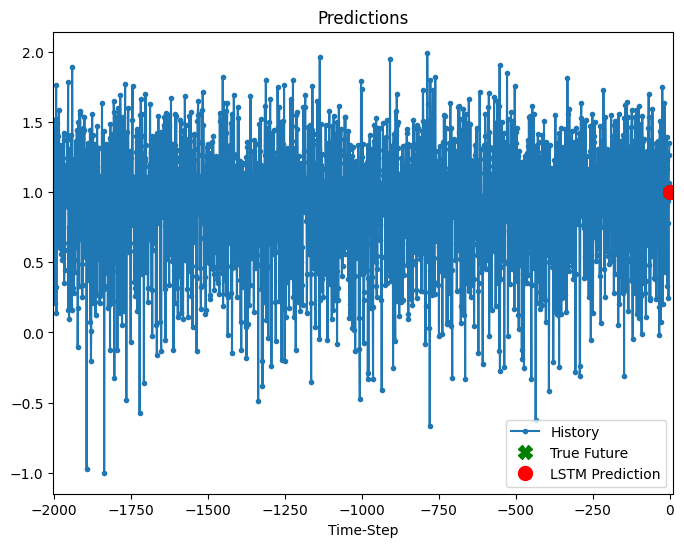

8/8 [==============================] - 1s 115ms/step


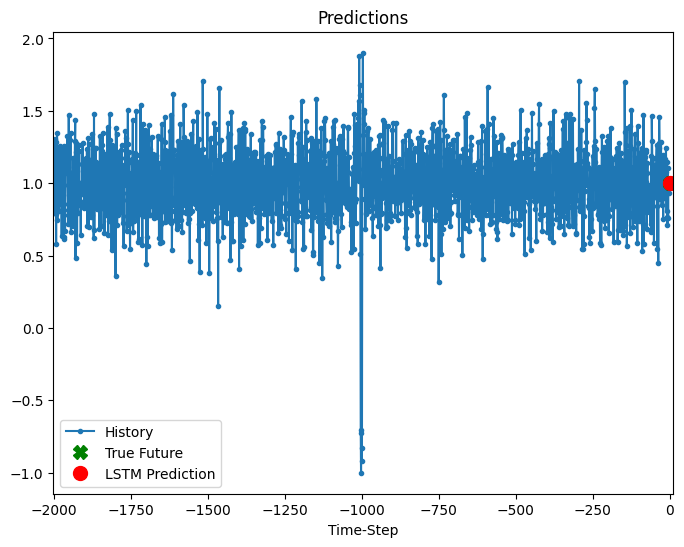

8/8 [==============================] - 1s 107ms/step


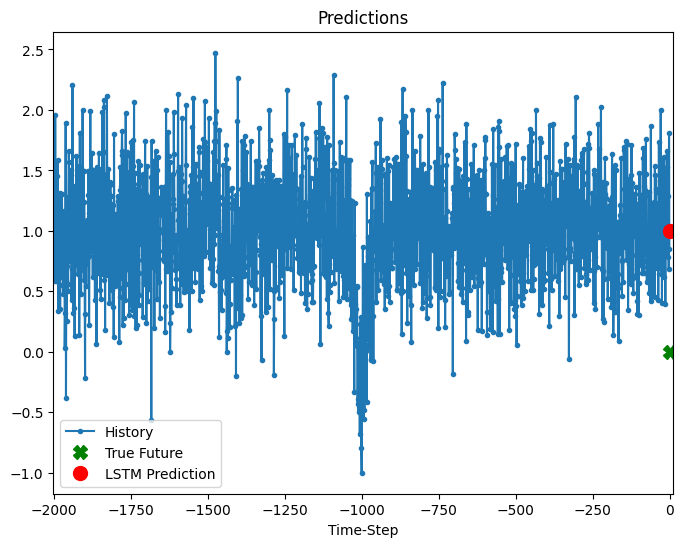

8/8 [==============================] - 1s 109ms/step


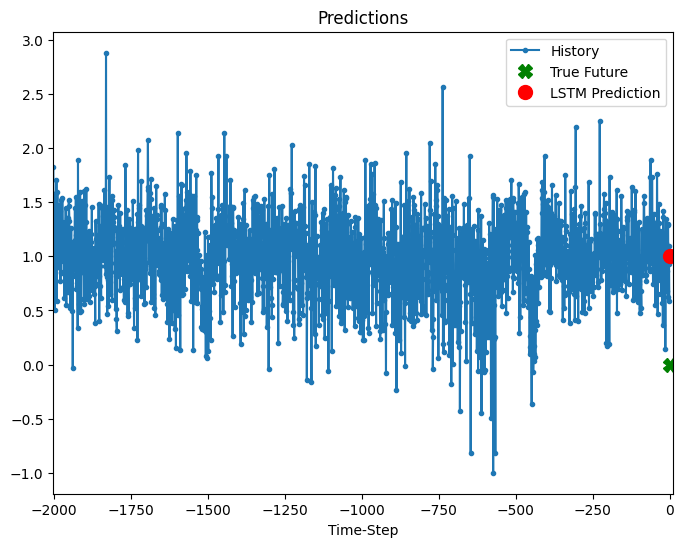

8/8 [==============================] - 1s 113ms/step


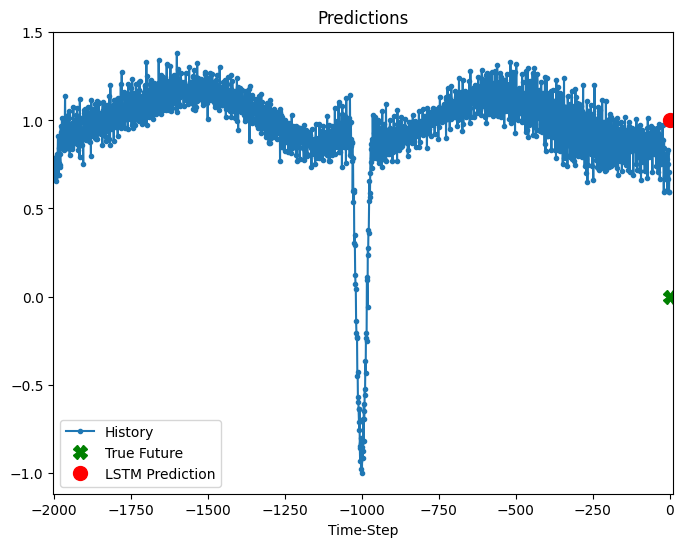

7/7 [==============================] - 1s 102ms/step
[0.4]


In [13]:
# Test LSTM data local
models.method_LSTM(x_train_uni, y_train_uni, x_val_uni, y_val_uni, univariate_past_history, future)

# Test LSTM data global
# models.method_LSTM(x_train_uni, y_train_uni, x_val_uni, y_val_uni)